In [2]:
#necessary Libraries
import numpy as np
import pandas as pd
import time
import pprint

#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
# magic word for producing visualizations in notebook
%matplotlib inline

#Preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA 
from scipy.sparse import lil_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#Models
from sklearn.naive_bayes import GaussianNB
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.adapt import MLkNN
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

#Scoring Metrics
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import f1_score, fbeta_score
from sklearn.metrics import accuracy_score

In [3]:
# Load the dataset
file_path = r'C:\Users\Thesis2.0\django_thesis\KNN Algorithm\ap_data_3.csv'
ap_data = pd.read_csv(file_path)

In [4]:
# Check the structure of the data after it's loaded 
#(print the number of rows and columns).
num_rows, num_cols  = ap_data.shape
print('Number of columns: {}'.format(num_cols))
print('Number of rows: {}'.format(num_rows))

Number of columns: 9
Number of rows: 698


In [5]:
#check the statistics of the data per columns
ap_data.describe()

,channel,signal_strength,floorid,latitude,longitude
count,698.000000,698.000000,698.000000,698.000000,698.000000
mean,2432.279370,-73.196275,160.885387,7.065805,125.596455
std,13.040084,11.953047,41.061783,0.000048,0.000016
min,2412.000000,-94.000000,101.000000,7.065735,125.596444
25%,2417.000000,-85.000000,101.000000,7.065735,125.596444
50%,2437.000000,-69.000000,189.000000,7.065837,125.596444
75%,2442.000000,-64.000000,189.000000,7.065837,125.596478
max,2452.000000,-50.000000,189.000000,7.065837,125.596478


In [6]:
#Check the columns names
col_names = ap_data.columns.values
col_names

array(['mac_address', 'ssid', 'channel', 'source', 'signal_strength',
       'floorid', 'latitude', 'longitude', 'timestamp'], dtype=object)

In [7]:
#check for missing values
missing_values_count = ap_data.isnull().sum()
#uncomment this if you want to see the count of missing data per column
#missing_values_count

# how many total missing values do we have?
total_cells = np.product(ap_data.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
missing_percent = (total_missing/total_cells) * 100

print('Percent of missing data = {}%'.format(missing_percent))

Percent of missing data = 0.0%


In [8]:
# Add a new column 'source_without_C' by removing 'C' from 'source'
ap_data['ssid'] = ap_data['ssid'].str.replace('C', '')

# Convert the 'source_without_C' column to numeric
ap_data['ssid'] = pd.to_numeric(ap_data['ssid'], errors='coerce')

In [9]:
ap_data = ap_data.drop(['mac_address'], axis=1)

#Check the columns names
col_names = ap_data.columns.values
col_names

array(['ssid', 'channel', 'source', 'signal_strength', 'floorid',
       'latitude', 'longitude', 'timestamp'], dtype=object)

In [10]:
#Assess unique values per columns
#unique_mac_address = ap_data["mac_address"].unique()
unique_ssid = ap_data["ssid"].unique()
unique_channel = ap_data["channel"].unique()
unique_floorid = ap_data["floorid"].unique()

#print('Unique Mac Address : {}'.format(unique_mac_address))
print('Unique SSID : {}'.format(unique_ssid))
print('Unique Channel : {}'.format(unique_channel))
print('Unique Floor ID : {}'.format(unique_floorid))


Unique SSID : [1 2]
Unique Channel : [2417 2422 2412 2427 2447 2442 2452 2437 2432]
Unique Floor ID : [101 189]


In [56]:
# Define the columns for duplication check
duplication_columns = ['ssid', 'channel', 'source', 'signal_strength', 'floorid']

# Count the number of occurrences for each combination of columns
ap_data['duplication_count'] = ap_data.groupby(duplication_columns)['ssid'].transform('count')

# Filter rows where duplication count is greater than or equal to 4
filtered_data = ap_data[ap_data['duplication_count'] >= 6]

# Save the result to a new CSV file or modify the original dataframe as needed
filtered_data.to_csv('filtered_data.csv', index=False)

print(filtered_data)

# Group by duplication columns and aggregate values using, for example, the mean
merged_data = filtered_data.groupby(duplication_columns, as_index=False).mean()

# Drop the 'duplication_count' column if you don't need it in the final result
merged_data = merged_data.drop(columns=['duplication_count'])

# Save the result to a new CSV file or modify the original dataframe as needed
merged_data.to_csv('merged_data.csv', index=False)

print(merged_data)

     ssid  channel source  signal_strength  floorid  latitude   longitude  \
3       1     2412   cap3              -89      101  7.065735  125.596478   
5       1     2412   cap2              -67      101  7.065735  125.596478   
6       1     2412   cap3              -89      101  7.065735  125.596478   
8       1     2412   cap3              -89      101  7.065735  125.596478   
10      1     2412   cap3              -89      101  7.065735  125.596478   
..    ...      ...    ...              ...      ...       ...         ...   
665     1     2442   cap1              -57      189  7.065837  125.596444   
674     2     2442   cap2              -68      189  7.065837  125.596444   
681     2     2442   cap2              -68      189  7.065837  125.596444   
686     2     2442   cap2              -68      189  7.065837  125.596444   
693     1     2442   cap1              -62      189  7.065837  125.596444   

            timestamp  duplication_count  
3    24/11/2023 12:02           

In [57]:
# Count unique channels for each ssid, floorid, and source
result = merged_data.groupby(['ssid', 'floorid', 'source'])['channel'].nunique().reset_index()

print(result)

   ssid  floorid source  channel
0     1      101   cap1        1
1     1      101   cap2        3
2     1      101   cap3        1
3     1      189   cap1        1
4     1      189   cap2        1
5     1      189   cap3        2
6     2      189   cap1        1
7     2      189   cap2        2
8     2      189   cap3        2


In [98]:
# Define a custom aggregation function to calculate the product
def calculate_product(x):
    return x.prod()

# Group by 'ssid' and 'floorid', then aggregate using the custom function
result = result.groupby(['ssid', 'floorid']).agg({
    'channel': calculate_product
}).reset_index()

# Display the result
print(result)

# Continue from the previous code
total_sum_combination = result['channel'].sum()

print()

# Display the total sum
print("Total Sum of 'channel' values:", total_sum_combination)

# Calculate total RSSI for each unique channel within each ssid, floorid, and source
total_number_rssi = merged_data.groupby(['ssid', 'floorid', 'source', 'channel'])['signal_strength'].nunique().reset_index()

print(total_number_rssi)

   ssid  floorid  channel
0     1      101        3
1     1      189        2
2     2      189        4

Total Sum of 'channel' values: 9
    ssid  floorid source  channel  signal_strength
0      1      101   cap1     2417                2
1      1      101   cap2     2412                2
2      1      101   cap2     2417                3
3      1      101   cap2     2422                1
4      1      101   cap3     2412                2
5      1      189   cap1     2442                2
6      1      189   cap2     2442                2
7      1      189   cap3     2437                3
8      1      189   cap3     2442                1
9      2      189   cap1     2442                1
10     2      189   cap2     2442                2
11     2      189   cap2     2447                1
12     2      189   cap3     2437                3
13     2      189   cap3     2442                2


In [114]:
print(total_number_rssi)

# Create a dictionary to store the unique channels and signal strengths for each source
channel_counts = {}
for index, row in total_number_rssi.iterrows():
    if row['source'] not in channel_counts:
        channel_counts[row['source']] = {}

    if row['channel'] not in channel_counts[row['source']]:
        channel_counts[row['source']][row['channel']] = set()

    # Check if 'signal_strength' is a list before updating
    if isinstance(row['signal_strength'], list):
        channel_counts[row['source']][row['channel']].update(row['signal_strength'])

# Calculate the total number of rows
total_rows = 0
for ssid, floorid in total_number_rssi[['ssid', 'floorid']].drop_duplicates().itertuples(index=False):
    sources = total_number_rssi[total_number_rssi['ssid'] == ssid]['source'].unique()
    unique_combinations = []

    for combination in product(*[channel_counts[source][channel] for source in sources for channel in channel_counts[source]]):
        unique_combinations.append(combination)

    total_rows += len(unique_combinations)

print("Total number of rows:", total_rows)

    ssid  floorid source  channel  signal_strength
0      1      101   cap1     2417                2
1      1      101   cap2     2412                2
2      1      101   cap2     2417                3
3      1      101   cap2     2422                1
4      1      101   cap3     2412                2
5      1      189   cap1     2442                2
6      1      189   cap2     2442                2
7      1      189   cap3     2437                3
8      1      189   cap3     2442                1
9      2      189   cap1     2442                1
10     2      189   cap2     2442                2
11     2      189   cap2     2447                1
12     2      189   cap3     2437                3
13     2      189   cap3     2442                2
Total number of rows: 0


In [102]:
import pandas as pd
from itertools import product


# Step 1: Extract unique combinations of 'ssid' and 'floorid'
combinations = merged_data[['ssid', 'floorid']].drop_duplicates()

# Step 2: Calculate unique channels for each source
channel_counts = {}
for index, row in combinations.iterrows():
    ssid, floorid = row['ssid'], row['floorid']
    channels = merged_data[(merged_data['ssid'] == ssid) & (merged_data['floorid'] == floorid)].groupby('source')['channel'].unique()
    channel_counts[(ssid, floorid)] = channels
    
print(channel_counts)

# Step 3 and 4: Generate combinations and create DataFrame
combinations_list = []
for (ssid, floorid), channels in channel_counts.items():
    for source, channel_list in channels.items():
        for channel in channel_list:
            signal_strengths = merged_data[
                (merged_data['ssid'] == ssid) &
                (merged_data['floorid'] == floorid) &
                (merged_data['source'] == source) &
                (merged_data['channel'] == channel)
            ]['signal_strength'].tolist()
            
            total_signal_strengths = len(signal_strengths)
            
            print(f'SSID: {ssid}, FloorID: {floorid}, Total Number of Signal Strength for {source} channel {channel}: {total_signal_strengths}')
            
            combination = [ssid, floorid, source, f'channel_{channel}_signal_strength_{source}', signal_strengths]
            combinations_list.append(combination)

print(combinations_list)


{(1, 101): source
cap1                [2417]
cap2    [2412, 2417, 2422]
cap3                [2412]
Name: channel, dtype: object, (1, 189): source
cap1          [2442]
cap2          [2442]
cap3    [2437, 2442]
Name: channel, dtype: object, (2, 189): source
cap1          [2442]
cap2    [2442, 2447]
cap3    [2437, 2442]
Name: channel, dtype: object}
SSID: 1, FloorID: 101, Total Number of Signal Strength for cap1 channel 2417: 2
SSID: 1, FloorID: 101, Total Number of Signal Strength for cap2 channel 2412: 2
SSID: 1, FloorID: 101, Total Number of Signal Strength for cap2 channel 2417: 3
SSID: 1, FloorID: 101, Total Number of Signal Strength for cap2 channel 2422: 1
SSID: 1, FloorID: 101, Total Number of Signal Strength for cap3 channel 2412: 2
SSID: 1, FloorID: 189, Total Number of Signal Strength for cap1 channel 2442: 2
SSID: 1, FloorID: 189, Total Number of Signal Strength for cap2 channel 2442: 2
SSID: 1, FloorID: 189, Total Number of Signal Strength for cap3 channel 2437: 3
SSID: 1, Fl

In [64]:
# Step 5: Combine the RSSI from each row
combined_rssi = pd.DataFrame(columns=['ssid', 'floorid', 'channel_cap1', 'channel_cap2', 'channel_cap3', 'signal_strength_cap1', 'signal_strength_cap2', 'signal_strength_cap3'])

for (ssid, floorid), channels in channel_counts.items():
    product_list = product(*(channels[source] for source in channels.keys()))

    for combination in product_list:
        row = {'ssid': ssid, 'floorid': floorid}
        for i, (source, channel) in enumerate(zip(channels.keys(), combination), start=1):
            row[f'channel_{source}'] = channel
            signal_strengths = merged_data[
                (merged_data['ssid'] == ssid) &
                (merged_data['floorid'] == floorid) &
                (merged_data['source'] == source) &
                (merged_data['channel'] == channel)
            ]['signal_strength'].tolist()

            row[f'signal_strength_cap{i}'] = signal_strengths if signal_strengths else None

        combined_rssi = combined_rssi.append(row, ignore_index=True)

print(combined_rssi)

  ssid floorid channel_cap1 channel_cap2 channel_cap3 signal_strength_cap1  \
0    1     101         2417         2412         2412           [-54, -52]   
1    1     101         2417         2417         2412           [-54, -52]   
2    1     101         2417         2422         2412           [-54, -52]   
3    1     189         2442         2442         2437           [-62, -57]   
4    1     189         2442         2442         2442           [-62, -57]   
5    2     189         2442         2442         2437                [-65]   
6    2     189         2442         2442         2442                [-65]   
7    2     189         2442         2447         2437                [-65]   
8    2     189         2442         2447         2442                [-65]   

  signal_strength_cap2 signal_strength_cap3  
0           [-68, -67]           [-93, -89]  
1      [-65, -62, -58]           [-93, -89]  
2                [-63]           [-93, -89]  
3           [-72, -62]      [-89, -

In [67]:
# Step 6: Combine the RSSI from each row
combined_rssi_final = pd.DataFrame(columns=combined_rssi.columns)  # Initialize an empty DataFrame

for index, row in combined_rssi.head(total_sum_combination).iterrows():  # Iterate only over the first 9 rows
    ssid, floorid, channel_cap1, channel_cap2, channel_cap3 = row['ssid'], row['floorid'], row['channel_cap1'], row['channel_cap2'], row['channel_cap3']
    
    # Create all possible combinations of signal strengths
    signal_combinations = product(*[row['signal_strength_cap1'], row['signal_strength_cap2'], row['signal_strength_cap3']])
    
    for signals in signal_combinations:
        combined_rssi_final = combined_rssi_final.append({
            'ssid': ssid,
            'floorid': floorid,
            'channel_cap1': channel_cap1,
            'channel_cap2': channel_cap2,
            'channel_cap3': channel_cap3,
            'signal_strength_cap1': signals[0],
            'signal_strength_cap2': signals[1],
            'signal_strength_cap3': signals[2]
        }, ignore_index=True)

# Display the result
print(combined_rssi_final)


   ssid floorid channel_cap1 channel_cap2 channel_cap3 signal_strength_cap1  \
0     1     101         2417         2412         2412                  -54   
1     1     101         2417         2412         2412                  -54   
2     1     101         2417         2412         2412                  -54   
3     1     101         2417         2412         2412                  -54   
4     1     101         2417         2412         2412                  -52   
5     1     101         2417         2412         2412                  -52   
6     1     101         2417         2412         2412                  -52   
7     1     101         2417         2412         2412                  -52   
8     1     101         2417         2417         2412                  -54   
9     1     101         2417         2417         2412                  -54   
10    1     101         2417         2417         2412                  -54   
11    1     101         2417         2417         24

In [68]:
# Check the structure of the data after it's loaded 
#(print the number of rows and columns).
num_rows, num_cols  = combined_rssi_final.shape
print('Number of columns: {}'.format(num_cols))
print('Number of rows: {}'.format(num_rows))

Number of columns: 8
Number of rows: 55


In [9]:
#Preprocess the Training Data Set //////////////////////////////////////////////////////////////////////////////////////////////

In [69]:
# Load the dataset
trainingData = combined_rssi_final

print(trainingData)

   ssid floorid channel_cap1 channel_cap2 channel_cap3 signal_strength_cap1  \
0     1     101         2417         2412         2412                  -54   
1     1     101         2417         2412         2412                  -54   
2     1     101         2417         2412         2412                  -54   
3     1     101         2417         2412         2412                  -54   
4     1     101         2417         2412         2412                  -52   
5     1     101         2417         2412         2412                  -52   
6     1     101         2417         2412         2412                  -52   
7     1     101         2417         2412         2412                  -52   
8     1     101         2417         2417         2412                  -54   
9     1     101         2417         2417         2412                  -54   
10    1     101         2417         2417         2412                  -54   
11    1     101         2417         2417         24

In [70]:
def clean_data(df):
    """
    Perform feature trimming, and engineering for trainingData
    Will also be applied to validationData
    
    INPUT: trainingData DataFrame
    OUTPUT: Trimmed and cleaned trainingData DataFrame
    """
    
    # Reverse the representation for the values. 100=0 and teh values range from 0-105 (weakest to strongest)
    #"The intensity values are represented as negative integer values ranging -104dBm (extremely poor signal) to 0dbM.
    #The positive value 100 is used to denote when a WAP was not detected."
    df.iloc[:, 5:8] = np.where(df.iloc[:, 5:8] <= 0, 
                df.iloc[:, 5:8] + 105, 
                df.iloc[:, 5:8] - 100)
    
    '''
    df.iloc[:, 6:9] = np.where(df.iloc[:, 6:9] > 2000, 
                df.iloc[:, 6:9] - 2300, 
                df.iloc[:, 6:9] - 0)
    '''
    
    # Remove rows if there are two zeroes in a row in the cap_channel
    df = df[
    ~((df['channel_cap1'] == 0) & (df['channel_cap2'] == 0)) &
    ~((df['channel_cap1'] == 0) & (df['channel_cap3'] == 0)) &
    ~((df['channel_cap2'] == 0) & (df['channel_cap3'] == 0))
    ]
    
   
    # Return the cleaned dataframe.
    return df 

In [72]:
#Apply Cleaning

trainingData  = clean_data(trainingData)


trainingData.to_csv('trainingData-ap_data_3.3.csv', index=False)

print(trainingData)

   ssid floorid channel_cap1 channel_cap2 channel_cap3 signal_strength_cap1  \
0     1     101         2417         2412         2412                   51   
1     1     101         2417         2412         2412                   51   
2     1     101         2417         2412         2412                   51   
3     1     101         2417         2412         2412                   51   
4     1     101         2417         2412         2412                   53   
5     1     101         2417         2412         2412                   53   
6     1     101         2417         2412         2412                   53   
7     1     101         2417         2412         2412                   53   
8     1     101         2417         2417         2412                   51   
9     1     101         2417         2417         2412                   51   
10    1     101         2417         2417         2412                   51   
11    1     101         2417         2417         24

In [75]:
import pandas as pd

def preprocess_data(df):
    """
    Separates trainingData into Features and Targets
    Will also be applied to validationData
    
    INPUT: Cleaned trainingData DataFrame
    OUTPUT: trainingData as Features and Targets
    """
    # split the data set into features and targets(Floor and BuildingID)
    X = df.drop(['floorid'], axis=1)
    y = df[['floorid']]
    
    # Extract unique channel values
    unique_channels = sorted(set(df['channel_cap1'].unique()) | set(df['channel_cap2'].unique()) | set(df['channel_cap3'].unique()))
    
    # Create new one-hot encoded columns
    for channel in unique_channels:
        X[f'channel_cap1_{channel}'] = (df['channel_cap1'] == channel).astype(int)
        X[f'channel_cap2_{channel}'] = (df['channel_cap2'] == channel).astype(int)
        X[f'channel_cap3_{channel}'] = (df['channel_cap3'] == channel).astype(int)
    
    # Drop the original 'channel_cap1', 'channel_cap2', and 'channel_cap3' columns
    X.drop(['channel_cap1', 'channel_cap2', 'channel_cap3'], axis=1, inplace=True)
    
    # Iterate over signal strength caps and channels to perform multiplication
    signal_columns = ['signal_strength_cap1', 'signal_strength_cap2', 'signal_strength_cap3']
    
    for signal_col in signal_columns:
        for channel in unique_channels:
            channel_col1 = f'channel_cap1_{channel}'
            channel_col2 = f'channel_cap2_{channel}'
            channel_col3 = f'channel_cap3_{channel}'
            
            if signal_col.endswith('cap1'):
                X[f'{signal_col}_{channel_col1}'] = df[signal_col] * X[channel_col1]
            elif signal_col.endswith('cap2'):
                X[f'{signal_col}_{channel_col2}'] = df[signal_col] * X[channel_col2]
            elif signal_col.endswith('cap3'):
                X[f'{signal_col}_{channel_col3}'] = df[signal_col] * X[channel_col3]

    # Drop the original 'signal_strength' columns
    X.drop(['signal_strength_cap1', 'signal_strength_cap2', 'signal_strength_cap3'], axis=1, inplace=True)
    
    # Drop unwanted columns
    unwanted_columns = [f'channel_cap{i}_{cap}' for i in range(1, 4) for cap in unique_channels]
    X.drop(unwanted_columns, axis=1, inplace=True)
    
    # create Dummies for the targets to feed into the model
    y = pd.get_dummies(data=y, columns=['floorid'])
    
    return X, y


In [76]:
#Apply preprocessing

X, y = preprocess_data(trainingData)


X.to_csv('X_values.csv', index=False)
y.to_csv('y_values.csv', index=False)

In [77]:
print(X)

'''
# Replace 'output_file.csv' with the desired file name
output_file = 'preprocessed_data2.csv'

# Save the DataFrame to a CSV file
X.to_csv(output_file, index=False)
'''


   ssid signal_strength_cap1_channel_cap1_2412  \
0     1                                      0   
1     1                                      0   
2     1                                      0   
3     1                                      0   
4     1                                      0   
5     1                                      0   
6     1                                      0   
7     1                                      0   
8     1                                      0   
9     1                                      0   
10    1                                      0   
11    1                                      0   
12    1                                      0   
13    1                                      0   
14    1                                      0   
15    1                                      0   
16    1                                      0   
17    1                                      0   
18    1                                      0   


"\n# Replace 'output_file.csv' with the desired file name\noutput_file = 'preprocessed_data2.csv'\n\n# Save the DataFrame to a CSV file\nX.to_csv(output_file, index=False)\n"

In [78]:
print(y)


    floorid_101  floorid_189
0             1            0
1             1            0
2             1            0
3             1            0
4             1            0
5             1            0
6             1            0
7             1            0
8             1            0
9             1            0
10            1            0
11            1            0
12            1            0
13            1            0
14            1            0
15            1            0
16            1            0
17            1            0
18            1            0
19            1            0
20            1            0
21            1            0
22            1            0
23            1            0
24            0            1
25            0            1
26            0            1
27            0            1
28            0            1
29            0            1
30            0            1
31            0            1
32            0            1
33            

In [79]:
def split_data(preprocess_data):
# TO AVOID OVERFITTING: Split the training data into training and testing sets 
    global X_train
    global X_test
    global y_train
    global y_test
    
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size = 0.2, 
                                                        random_state = 42,
                                                        shuffle=True)

    # Show the results of the split
    print("Training set has {} samples.".format(X_train.shape[0]))
    print("Testing set has {} samples.".format(X_test.shape[0]))
    return X_train, X_test, y_train, y_test

In [80]:
#Apply split data

X_train, X_test, y_train, y_test = split_data(preprocess_data)



Training set has 44 samples.
Testing set has 11 samples.


In [138]:
#Scale Data with Standard Scaler

scaler = StandardScaler()

#Fit only the training set
#this will help us transform the validation data 
scaler.fit(X_train)
    
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

k = 1  # You can adjust the value of k
knn = KNeighborsClassifier(n_neighbors=k, p=2, metric = 'euclidean')  # p=2 for Euclidean metric
knn.fit(X_train, y_train)

# Assuming 'knn' is your trained KNN classifier
# Assuming 'X_test' and 'y_test' are your test features and labels
y_pred = knn.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 100.00%


In [133]:


cm = confusion_matrix(y_test, y_pred)
print(cm)

ValueError: multilabel-indicator is not supported

In [120]:
#Apply PCA while keeping 95% of the variation in the data
pca = PCA(.95)

    
#Fit only the training set    
pca.fit(X_train)

# Apply PCA transform to both the training set and the test set.    
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("Number of PCA Components = {}.".format(pca.n_components_))
#print(pca.n_components_)
print("Total Variance Explained by PCA Components = {}.".format(pca.explained_variance_ratio_.sum()))
#print(pca.explained_variance_ratio_.sum())

Number of PCA Components = 5.
Total Variance Explained by PCA Components = 0.9531693067790056.


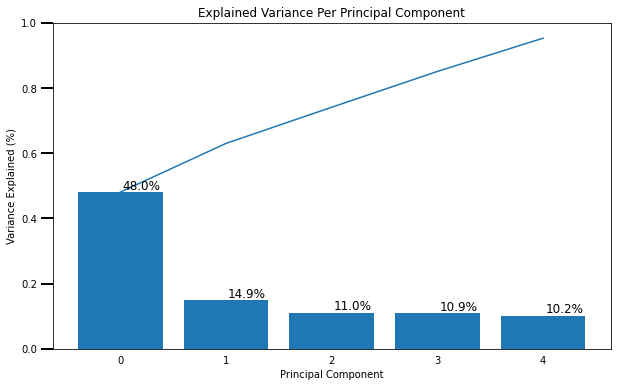

In [121]:
def pca_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
pca_plot(pca)

In [122]:
#Create sparse matrices to run the scikit multilearn algorithms

X_train_pca = lil_matrix(X_train_pca).toarray()
y_train = lil_matrix(y_train).toarray()
X_test_pca = lil_matrix(X_test_pca).toarray()
y_test = lil_matrix(y_test).toarray()

In [123]:
# using binary relevance
# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
start_time = time.time()

BR_classifier = BinaryRelevance(GaussianNB())
# train
BR_classifier.fit(X_train, y_train)
# predict
predictions = BR_classifier.predict(X_test)
# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions))

print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))


Accuracy =  1.0
--- Run time: 0.0 mins ---


In [124]:
start_time = time.time()

MLKNN_classifier = MLkNN(k=1)

# train
MLKNN_classifier.fit(X_train_pca, y_train)

# predict mlknn =3
predictions = MLKNN_classifier.predict(X_test_pca)

# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions))

print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))

Accuracy =  1.0
--- Run time: 0.0 mins ---


C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_neighbors=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [125]:
dense_predictions = predictions.toarray()
print("Type of dense_predictions:", type(dense_predictions))
print("Shape of dense_predictions:", dense_predictions.shape)


Type of dense_predictions: <class 'numpy.ndarray'>
Shape of dense_predictions: (11, 2)


In [127]:
start_time = time.time()

MLKNN_classifier = MLkNN(k=1)

# train
MLKNN_classifier.fit(X_train_pca, y_train)

# predict mlknn =3
predictions = MLKNN_classifier.predict(X_test_pca)

# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions))

print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))

Accuracy =  1.0
--- Run time: 0.0 mins ---


C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_neighbors=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
